# Image search based on visual similarity

## Version 2.0 of the code

### Optimizations
- Divide the code into training and testing part
- Don't keep the feature vectors knn model in memory save it after training and retrieve for testing
- Lets not calculate the feature vector for test image online. We'll use saved feature vectors from training phase


## Training / Pre-processing code

In [29]:
# Loading required modules

from keras.applications import vgg16
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import os
import numpy as np
from sklearn.externals import joblib
import time

In [30]:
# Define constants

IMGS_PATH = "smalldata\\images\\"

# Size as per VGG16 input layer size
IMGS_WIDTH, IMGS_HEIGHT = 224, 224 

#Kept small value for quick demo
DATA_SIZE = 1000 

In [31]:
# load VGG16 model with weights from imagenet dataset
vgg_model = vgg16.VGG16(weights='imagenet')

# Take only the last layer which contains the feature vector
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

In [32]:
files = [IMGS_PATH + x for x in os.listdir(IMGS_PATH) if "jpg" in x]

files = files[:DATA_SIZE]
print("Total images:",len(files))

Total images: 1000


In [33]:
imported_imgs = []

for file in files:
    filename = file
    test_img = load_img(filename, target_size=(IMGS_WIDTH, IMGS_HEIGHT))
    np_img = img_to_array(test_img)
    # Add additional axis so that first dimension becomes number images added
    image_batch = np.expand_dims(np_img, axis=0)
        
    imported_imgs.append(image_batch)

# Create vertically stacked images
imgs = np.vstack(imported_imgs)

# Use custom function given by Keras for pre-processing data compatible with ImageNet
processed_imgs = preprocess_input(imgs.copy())

print('Input image array processing done!')
print('Array Size:', processed_imgs.shape)

Input image array processing done!
Array Size: (1000, 224, 224, 3)


In [34]:
# extract the images features

start_time = time.process_time()

# Run the feature extractor on all stacked input images
imgs_features = feat_extractor.predict(processed_imgs)

print("All input image features successfully extracted!")
print('Features matrix size:', imgs_features.shape)
end_time = time.process_time()
print('Time required for extracting features:',(end_time - start_time), 'sec')

All input image features successfully extracted!
Features matrix size: (1000, 4096)
Time required for extracting features: 1488.625 sec


In [35]:
# number of most similar images to retrieve
# One extra result will be distance calculated with test image itself thus 11
N_CLOSEST_IMGS = 11 

nbrs = NearestNeighbors(n_neighbors=N_CLOSEST_IMGS,metric='cosine')

# Fits the data to the KNN model, also makes querying faster
nbrs.fit(imgs_features)

# save image features and KNN model
joblib.dump(imgs_features,'imgs_features_v20.pkl')
joblib.dump(nbrs,'knn_model_v20.pkl')

['knn_model_v20.pkl']

## Test Code

In [1]:
from keras.preprocessing.image import load_img,img_to_array
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.externals import joblib
import random
from sklearn.neighbors import NearestNeighbors
import time

DATA_SIZE = 1000

N_CLOSEST_IMGS = 11 

IMGS_PATH = "smalldata\\images\\"

files = [IMGS_PATH + x for x in os.listdir(IMGS_PATH) if "jpg" in x]

files = files[:DATA_SIZE]
print("Total images:",len(files))

Using TensorFlow backend.
C:\Users\meetm\anaconda3\envs\tensormay\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Total images: 1000


In [2]:
def get_similar_images(test_img_index):  
     
    start_time = time.perf_counter()
      
    nbrs = joblib.load('knn_model_v20.pkl')
    imgs_features = joblib.load('imgs_features_v20.pkl')
    
    # Get test image feature vector
    test_img_feat_vec = imgs_features[test_img_index] 
      
    # Calculate closes n_closest_imgs feature vectors (and images) to test feature vector
    distances, indices = nbrs.kneighbors(test_img_feat_vec[None])

    end_time = time.perf_counter()
    
    print('Execution time for search:',int((end_time-start_time) * 1000),'millisec')
    # Display Test image
    print("***********************************************************************")
    print("Test Image :",test_img_index)
    test_img = load_img(files[test_img_index])
    plt.imshow(test_img)
    plt.show()

    # Display matching images results
    print("***********************************************************************")
    print("Image results based on KNN similarity:")
    # Create a grid of 2x5 to display 10 matching images properly
    f, axarr = plt.subplots(2,5)
    plt.subplots_adjust(right=1.5,hspace=0.5)

    for i in range(1,N_CLOSEST_IMGS):
        res = load_img(files[indices[0][i]])
        axarr[(i-1)//5][(i-1)%5].imshow(res)
        axarr[(i-1)//5][(i-1)%5].set_title(str(round(distances[0][i],4)))

Execution time for search: 134 millisec
***********************************************************************
Test Image : 182


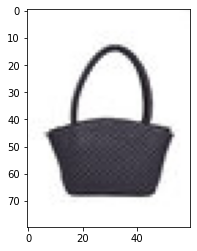

***********************************************************************
Image results based on KNN similarity:


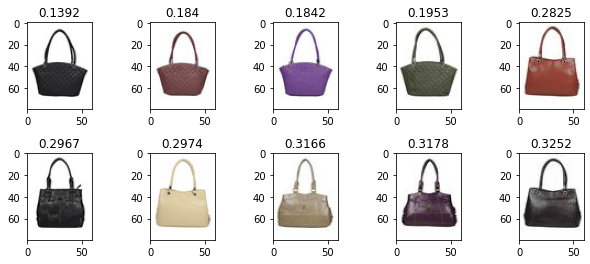

In [3]:
# Get a random test image from given dataset and retrive n_closest_imgs similar images
# Alternatively we can also send a completely new test image which is not part of database
test_img_index = random.randint(0,DATA_SIZE)

# Function to search the input test image and display similar results
get_similar_images(test_img_index)